In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select, distinct

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Tiasc\AppData\Local\Temp\ipykernel_29548\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
print("Tables in the reflected model:")
for table_name in Base.classes.keys():
    print(table_name)

Tables in the reflected model:
measurement
station


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
Session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = Session.query(measurement.date).order_by(measurement.date.desc()).first()
print("Most Recent Date:", most_recent_date)

Most Recent Date: ('2017-08-23',)


In [12]:
# Find the most recent date in the data set.
first_date = Session.query(measurement.date).order_by(measurement.date).first()
first_date

('2010-01-01',)

In [14]:
#Find the date 1 year from the last date
start_date = date(2017, 8, 23)
one_year_from_start = start_date - timedelta(days=365)
print("One Year Previous from Most Recent Date:", one_year_from_start)

One Year Previous from Most Recent Date: 2016-08-23


<Figure size 1000x300 with 0 Axes>

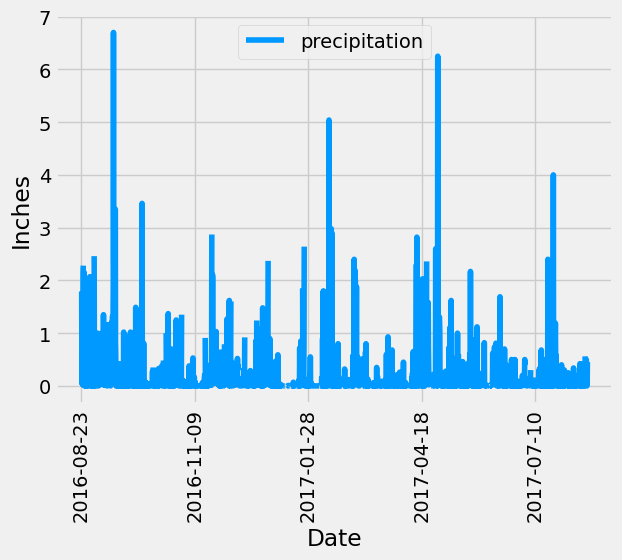

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = Session.query(measurement.date).order_by(measurement.date.desc()).first()

# Calculate the date one year from the last date in data set and perform a query to retrieve the data and precipitation scores
one_year_date = Session.query(measurement.date, measurement.prcp).filter(measurement.date >= dt.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_score = pd.DataFrame(one_year_date, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_score.set_index(precip_score['date'], inplace=True)
precip_score = precip_score.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 3))
precip_score.plot(rot=90, color="#0099FF")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='best')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_score.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = Session.query(station).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = Session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
most_active_station_id = Session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()
most_active_station_id

('USC00519281', 2772)

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = Session.query(func.min(measurement.tobs).label('lowest_temp'),
                                  func.max(measurement.tobs).label('highest_temp'),
                                  func.avg(measurement.tobs).label('average_temp')).\
    filter(measurement.station == most_active_station_id).first()

print(f"Temperature statistics for the most active station (Station {most_active_station_id}):")
print(f"Lowest Temperature: {temperature_stats.lowest_temp}")
print(f"Highest Temperature: {temperature_stats.highest_temp}")
print(f"Average Temperature: {temperature_stats.average_temp}")

Temperature statistics for the most active station (Station USC00519281):
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


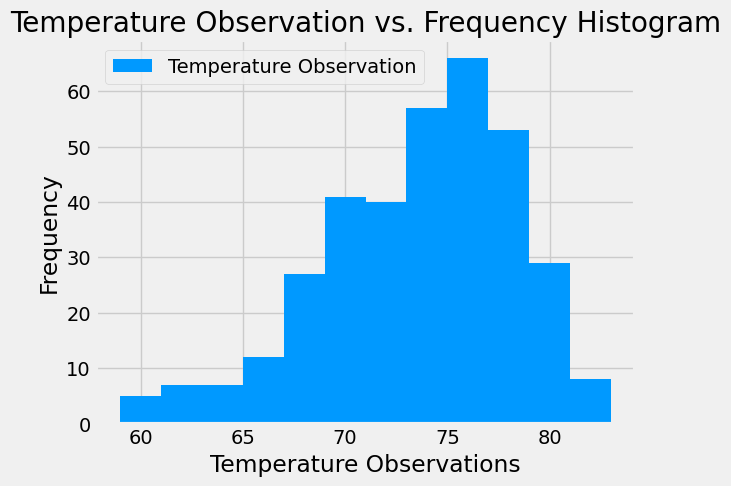

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = Session.query(measurement.date, measurement.tobs).filter(measurement.date >= '2016-08-23').filter(measurement.station == most_active_station_id).all()


temperature_data = pd.DataFrame(temperature_data, columns=['Date', 'Temperature Observation'])
temperature_data.set_index('Date', inplace=True)
temperature_data.plot.hist(bins=12, title="Temperature Observation vs. Frequency Histogram", color="#0099FF")
plt.tight_layout()
plt.xlabel("Temperature Observations")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.show()

# Close Session

In [185]:
# Close Session
Session.close()